In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame = False)

In [2]:
mnist.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
mnist.target

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [4]:
X,Y = mnist.data,mnist.target

In [5]:
X.shape

(70000, 784)

In [6]:
Y.shape

(70000,)

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image,cmap = 'binary')
    plt.axis('off')

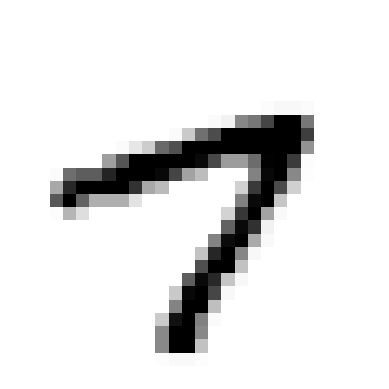

In [8]:
plot_digit(X[101])

In [9]:
X_train,Y_train = X[:60000],Y[:60000]
X_test,Y_test = X[60000:],Y[60000:]

In [10]:
from sklearn.preprocessing import StandardScaler
# Avoid this scaling because it impacted the accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_clf.fit(X_train,Y_train)
knn_clf.score(X_test,Y_test)

0.9688

In [12]:
from sklearn.model_selection import cross_val_predict,cross_val_score

cross_val_score(knn_clf,X_train,Y_train,cv = 3,n_jobs=-1,scoring='accuracy')

array([0.9676 , 0.9671 , 0.96755])

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
Y_train_pred = cross_val_predict(knn_clf,X_train,Y_train,cv = 3, n_jobs=-1)

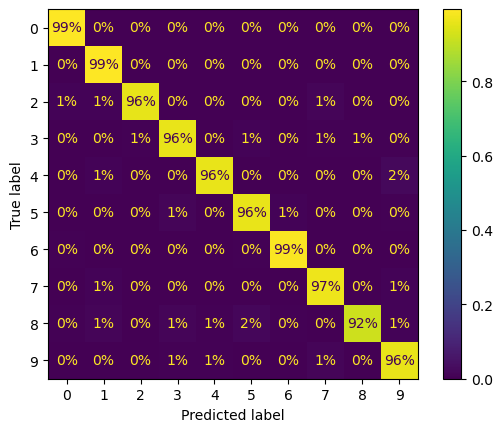

In [14]:
ConfusionMatrixDisplay.from_predictions(Y_train,Y_train_pred,normalize='true',values_format='.0%')
plt.show()

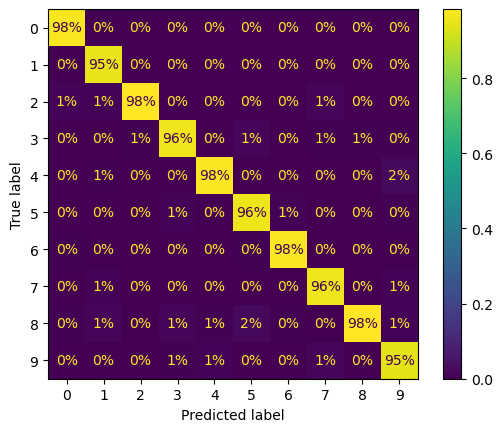

In [15]:
ConfusionMatrixDisplay.from_predictions(Y_train,Y_train_pred,normalize='pred',values_format='.0%')
plt.show()

In [16]:
from sklearn.metrics import f1_score

f1_score(Y_train,Y_train_pred,average='macro')

0.9672164755274893

In [17]:
KNeighborsClassifier()

KNeighborsClassifier()

In [21]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = [
    {'n_neighbors':[4,5,6,8,10],
     'weights':['distance','uniform']},
     
]

grid_search = GridSearchCV(knn_clf,param_grid=param_grid,cv = 3,scoring = 'accuracy',n_jobs=-3)
grid_search.fit(X_train[:10000],Y_train[:10000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-3,
             param_grid=[{'n_neighbors': [4, 5, 6, 8, 10],
                          'weights': ['distance', 'uniform']}],
             scoring='accuracy')

In [22]:
grid_search.best_score_

0.9397994088551026

In [23]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [24]:
import pandas as pd

grid_res_df = pd.DataFrame(grid_search.cv_results_)
grid_res_df[['param_n_neighbors','param_weights','mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score')

,param_n_neighbors,param_weights,mean_test_score,rank_test_score
0,4,distance,0.939799,1
4,6,distance,0.937300,2
2,5,distance,0.937000,3
6,8,distance,0.936400,4
1,4,uniform,0.934800,5
8,10,distance,0.934500,6
3,5,uniform,0.933200,7
5,6,uniform,0.931800,8
7,8,uniform,0.930400,9
9,10,uniform,0.930300,10


In [25]:
X_test.shape

(10000, 784)

In [26]:
Y_test.shape

(10000,)

In [27]:
knn_clf_tuned = grid_search.best_estimator_

In [31]:
knn_clf_tuned.fit(X_train,Y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [32]:
from sklearn.metrics import accuracy_score

Y_test_pred = knn_clf_tuned.predict(X_test)
accuracy_score(Y_test,Y_test_pred)

0.9714

In [33]:
knn_clf_tuned.score(X_test,Y_test)

0.9714

In [96]:
import numpy as np
from scipy.ndimage import shift

def shift_image(image,shift_direction):
    image_data = image.reshape((28,28))
    if shift_direction == 'up':
        return shift(image_data,[-1,0],cval = 0).reshape([-1])
    elif shift_direction == 'down':
        return shift(image_data,[1,0],cval = 0).reshape([-1])
    elif shift_direction == 'left':
        return shift(image_data,[0,-1],cval = 0).reshape([-1])
    elif shift_direction == 'right':
        return shift(image_data,[0,1],cval = 0).reshape([-1])
    else:
        print('Not a valid choice')
        raise ValueError 

In [97]:
augmented_images = [image for image in X_train]
augmented_labels = [label for label in Y_train]

for image,label in zip(X_train,Y_train):
    for dir in ['up','down','left','right']:
        shifted_image = shift_image(image, dir)
        augmented_images.append(shifted_image)
        augmented_labels.append(label)
        
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [101]:
# For shuffling the augmented images + existing training set to not have them labelled together

shuffle_idx = np.random.permutation(len(augmented_images))
X_train_augmented = augmented_images[shuffle_idx]
y_train_augmented = augmented_labels[shuffle_idx]

In [103]:
y_train_augmented

array(['6', '5', '3', ..., '4', '0', '5'], dtype='<U1')

In [104]:
knn_clf_tuned.fit(X_train_augmented,y_train_augmented)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

In [ ]:
augmented_accuracy = knn_clf_tuned.score(X_test,Y_test)
augmented_accuracy # 0.9763 (0.5 greater than without data augmentation)

0.9763